In [47]:
!pip install requests beautifulsoup4 pandas matplotlib seaborn

In [48]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scrapping dari halaman utama

In [49]:
def scrape_books_from_page(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    books = soup.find_all('article', class_='product_pod')

    book_data = []

    for book in books:
        title = book.h3.a['title']
        price = book.find('p', class_='price_color').text[2:]  # Remove '£'
        rating = book.p['class'][1]  # e.g., 'Three'
        availability = book.find('p', class_='instock availability').text.strip()

        book_data.append({
            'Title': title,
            'Price': float(price),
            'Rating': rating,
            'Availability': availability
        })

    return book_data

In [50]:
all_books = []

base_url = 'http://books.toscrape.com/catalogue/page-{}.html'

for page in range(1, 51):
    url = base_url.format(page)
    books = scrape_books_from_page(url)
    all_books.extend(books)

df = pd.DataFrame(all_books)
df

,Title,Price,Rating,Availability
0,A Light in the Attic,51.77,Three,In stock
1,Tipping the Velvet,53.74,One,In stock
2,Soumission,50.10,One,In stock
3,Sharp Objects,47.82,Four,In stock
4,Sapiens: A Brief History of Humankind,54.23,Five,In stock
...,...,...,...,...
995,Alice in Wonderland (Alice's Adventures in Won...,55.53,One,In stock
996,"Ajin: Demi-Human, Volume 1 (Ajin: Demi-Human #1)",57.06,Four,In stock
997,A Spy's Devotion (The Regency Spies of London #1),16.97,Five,In stock
998,1st to Die (Women's Murder Club #1),53.98,One,In stock


In [51]:
df = pd.DataFrame(all_books)
print(df.columns)
df.head()

Index(['Title', 'Price', 'Rating', 'Availability'], dtype='object')


,Title,Price,Rating,Availability
0,A Light in the Attic,51.77,Three,In stock
1,Tipping the Velvet,53.74,One,In stock
2,Soumission,50.10,One,In stock
3,Sharp Objects,47.82,Four,In stock
4,Sapiens: A Brief History of Humankind,54.23,Five,In stock


In [52]:
rating_map = {
    'One': 1,
    'Two': 2,
    'Three': 3,
    'Four': 4,
    'Five': 5
}

df['Rating'] = df['Rating'].map(rating_map)
df['In_Stock'] = df['Availability'].apply(lambda x: 'In Stock' in x)
df.drop(columns='Availability', inplace=True)
df

,Title,Price,Rating,In_Stock
0,A Light in the Attic,51.77,3,False
1,Tipping the Velvet,53.74,1,False
2,Soumission,50.10,1,False
3,Sharp Objects,47.82,4,False
4,Sapiens: A Brief History of Humankind,54.23,5,False
...,...,...,...,...
995,Alice in Wonderland (Alice's Adventures in Won...,55.53,1,False
996,"Ajin: Demi-Human, Volume 1 (Ajin: Demi-Human #1)",57.06,4,False
997,A Spy's Devotion (The Regency Spies of London #1),16.97,5,False
998,1st to Die (Women's Murder Club #1),53.98,1,False


In [53]:
df.describe()

,Price,Rating
count,1000.00000,1000.000000
mean,35.07035,2.923000
std,14.44669,1.434967
min,10.00000,1.000000
25%,22.10750,2.000000
50%,35.98000,3.000000
75%,47.45750,4.000000
max,59.99000,5.000000


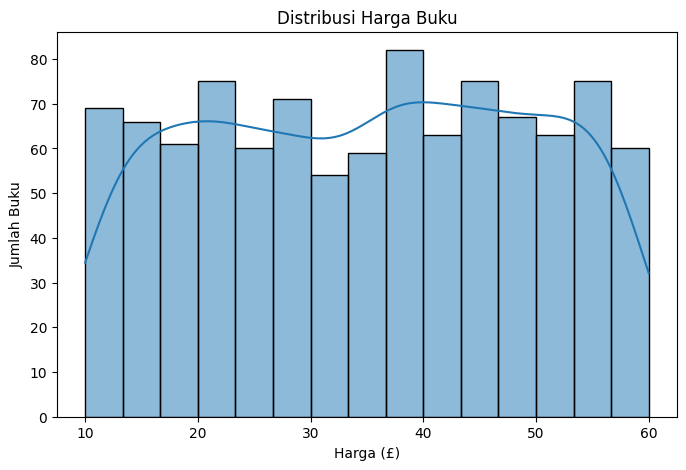

In [54]:
plt.figure(figsize=(8,5))
sns.histplot(df['Price'], bins=15, kde=True)
plt.title('Distribusi Harga Buku')
plt.xlabel('Harga (£)')
plt.ylabel('Jumlah Buku')
plt.show()

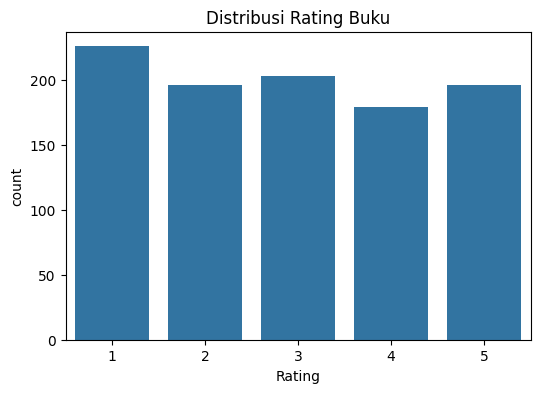

In [55]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Rating')
plt.title('Distribusi Rating Buku')
plt.show()

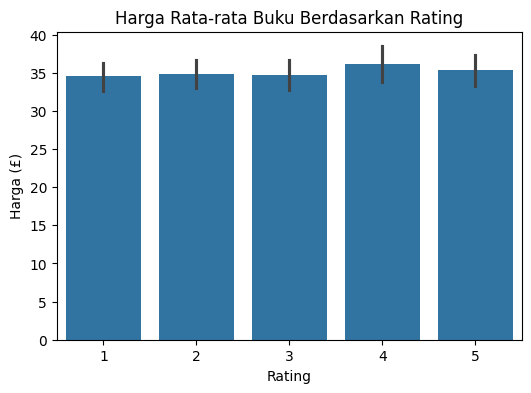

In [62]:
plt.figure(figsize=(6,4))
sns.barplot(data=df, x='Rating', y='Price')
plt.ylabel('Harga (£)')
plt.title('Harga Rata-rata Buku Berdasarkan Rating')
plt.show()

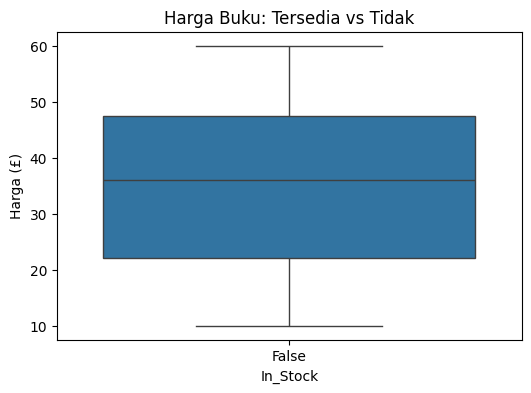

In [63]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x='In_Stock', y='Price')
plt.ylabel('Harga (£)')
plt.title('Harga Buku: Tersedia vs Tidak')
plt.show()

# Scrapping dari halaman tiap kategori buku

In [70]:
base_url = 'http://books.toscrape.com/'

def get_categories():
    response = requests.get(base_url)
    soup = BeautifulSoup(response.text, 'html.parser')
    category_links = soup.select('.side_categories ul li ul li a')

    categories = {}
    for cat in category_links:
        name = cat.text.strip()
        url = base_url + cat['href']
        categories[name] = url
    return categories

categories = get_categories()
list(categories.items())[:5]  # Tampilkan 5 kategori pertama

[('Travel',
  'http://books.toscrape.com/catalogue/category/books/travel_2/index.html'),
 ('Mystery',
  'http://books.toscrape.com/catalogue/category/books/mystery_3/index.html'),
 ('Historical Fiction',
  'http://books.toscrape.com/catalogue/category/books/historical-fiction_4/index.html'),
 ('Sequential Art',
  'http://books.toscrape.com/catalogue/category/books/sequential-art_5/index.html'),
 ('Classics',
  'http://books.toscrape.com/catalogue/category/books/classics_6/index.html')]

In [71]:
def scrape_category_books(category_name, category_url, max_pages=2):
    books = []
    for page in range(1, max_pages + 1):
        url = category_url.replace('index.html', f'page-{page}.html')
        response = requests.get(url)

        # Jika halaman tidak ditemukan (tidak semua kategori punya banyak halaman)
        if response.status_code != 200:
            break

        soup = BeautifulSoup(response.text, 'html.parser')
        articles = soup.find_all('article', class_='product_pod')

        for book in articles:
            title = book.h3.a['title']
            price = book.find('p', class_='price_color').text[2:]
            rating = book.p['class'][1]
            availability = book.find('p', class_='instock availability').text.strip()

            books.append({
                'Title': title,
                'Price': float(price),
                'Rating': rating,
                'Availability': availability,
                'Category': category_name
            })
    return books

In [76]:
all_books = []

for category, url in categories.items():
    books = scrape_category_books(category, url)
    all_books.extend(books)

df = pd.DataFrame(all_books)
df

,Title,Price,Rating,Availability,Category
0,Sharp Objects,47.82,Four,In stock,Mystery
1,"In a Dark, Dark Wood",19.63,One,In stock,Mystery
2,The Past Never Ends,56.50,Four,In stock,Mystery
3,A Murder in Time,16.64,One,In stock,Mystery
4,The Murder of Roger Ackroyd (Hercule Poirot #4),44.10,Four,In stock,Mystery
...,...,...,...,...,...
427,Mexican Today: New and Rediscovered Recipes fo...,24.91,Five,In stock,Food and Drink
428,Vegan Vegetarian Omnivore: Dinner for Everyone...,13.66,Two,In stock,Food and Drink
429,The Smitten Kitchen Cookbook,23.59,One,In stock,Food and Drink
430,"The Art of Simple Food: Notes, Lessons, and Re...",34.32,Three,In stock,Food and Drink


In [77]:
df.to_csv('scraped_books.csv', index=False)

In [78]:
rating_map = {'One': 1, 'Two': 2, 'Three': 3, 'Four': 4, 'Five': 5}
df['Rating'] = df['Rating'].map(rating_map)
df['In_Stock'] = df['Availability'].apply(lambda x: 'In Stock' in x)
df.drop(columns='Availability', inplace=True)
df

,Title,Price,Rating,Category,In_Stock
0,Sharp Objects,47.82,4,Mystery,False
1,"In a Dark, Dark Wood",19.63,1,Mystery,False
2,The Past Never Ends,56.50,4,Mystery,False
3,A Murder in Time,16.64,1,Mystery,False
4,The Murder of Roger Ackroyd (Hercule Poirot #4),44.10,4,Mystery,False
...,...,...,...,...,...
427,Mexican Today: New and Rediscovered Recipes fo...,24.91,5,Food and Drink,False
428,Vegan Vegetarian Omnivore: Dinner for Everyone...,13.66,2,Food and Drink,False
429,The Smitten Kitchen Cookbook,23.59,1,Food and Drink,False
430,"The Art of Simple Food: Notes, Lessons, and Re...",34.32,3,Food and Drink,False


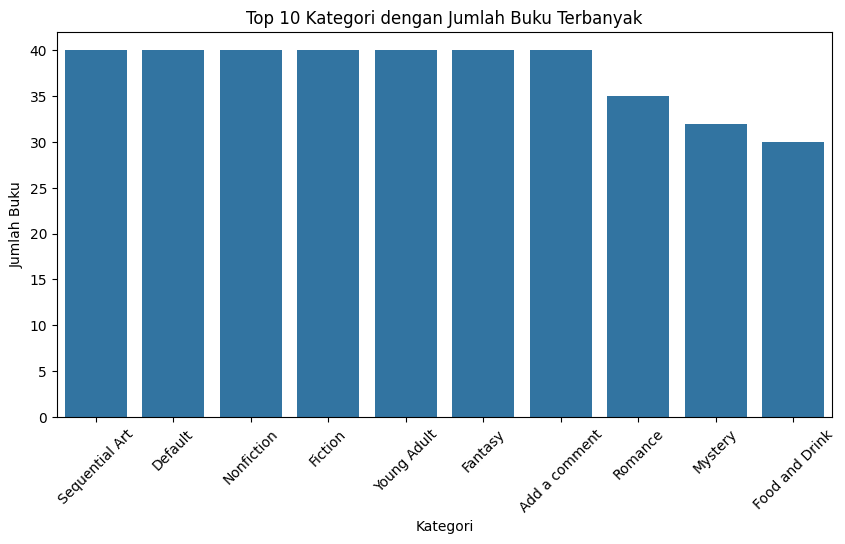

In [74]:
top_categories = df['Category'].value_counts().head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_categories.index, y=top_categories.values)
plt.xticks(rotation=45)
plt.title('Top 10 Kategori dengan Jumlah Buku Terbanyak')
plt.ylabel('Jumlah Buku')
plt.xlabel('Kategori')
plt.show()

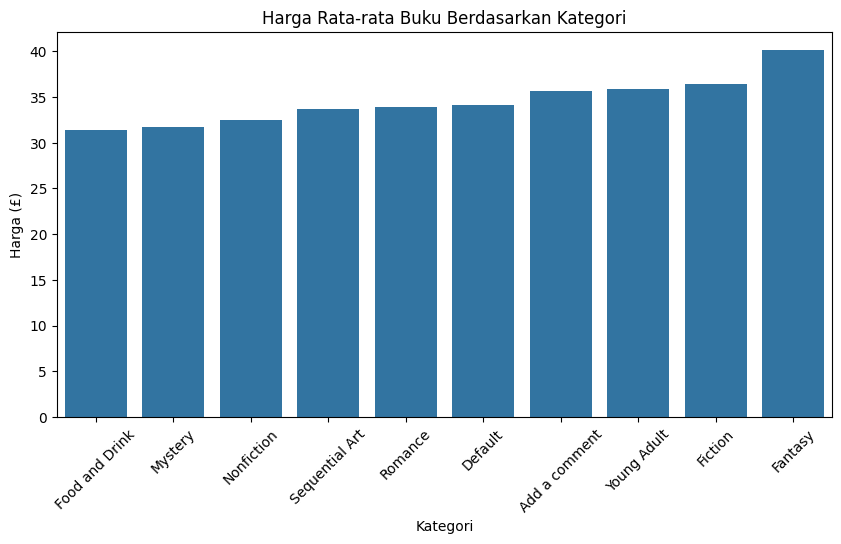

In [75]:
top_10_cats = df['Category'].value_counts().head(10).index
avg_price_per_cat = df[df['Category'].isin(top_10_cats)].groupby('Category')['Price'].mean().sort_values()

plt.figure(figsize=(10, 5))
sns.barplot(x=avg_price_per_cat.index, y=avg_price_per_cat.values)
plt.xticks(rotation=45)
plt.title('Harga Rata-rata Buku Berdasarkan Kategori')
plt.ylabel('Harga (£)')
plt.xlabel('Kategori')
plt.show()